In [1]:
# References
# Activating personal laptop GPUs: https://medium.com/@harunijaz/a-step-by-step-guide-to-installing-cuda-with-pytorch-in-conda-on-windows-verifying-via-console-9ba4cd5ccbef
# Compatibility Resource for TensorFlow: https://www.tensorflow.org/install/pip
# TensorFlow-GPU Install: https://anaconda.org/conda-forge/tensorflow-gpu, https://gist.github.com/anirban94chakraborty/0364e37ec1ddd57fe935fcf1e7fabd36, https://medium.com/analytics-vidhya/installing-tensorflow-gpu-on-anaconda-3f49c59c122b
# Original Code (modified in this project): https://github.com/rois-codh/kmnist/blob/master/benchmarks/kuzushiji_mnist_cnn.py

# Out of the Box CNN for KMNIST

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib

import torch
import torch.nn as nn

from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold

In [3]:
print(device_lib.list_local_devices())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16154660238304992307
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1725222094
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18330938343457261532
physical_device_desc: "device: 0, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:f3:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
cpu
Num GPUs Available:  1


In [4]:
# # setting device on GPU if available, else CPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using device:', device)
# print()

# #Additional Info when using cuda
# if device.type == 'cuda':
#     print(torch.cuda.get_device_name(0))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

48000 Train Samples, 12000 Validation Samples, 10000 Test Samples
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1

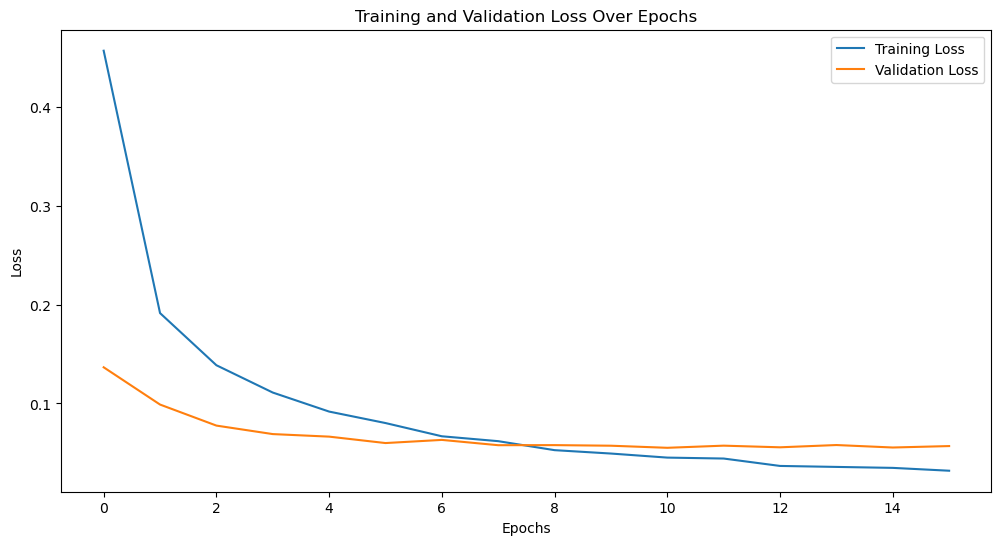

In [5]:
batch_size = 128
num_classes = 10
epochs = 30

# input image dimensions
img_rows, img_cols = 28, 28

def load_kmnist():
    data = {}
    data['x_train'] = np.load('./data/kmnist-train-imgs.npz')['arr_0']
    data['y_train'] = np.load('./data/kmnist-train-labels.npz')['arr_0']
    data['x_test'] = np.load('./data/kmnist-test-imgs.npz')['arr_0']
    data['y_test'] = np.load('./data/kmnist-test-labels.npz')['arr_0']
    return data

data = load_kmnist()
x_train, x_val, y_train, y_val = train_test_split(data['x_train'], data['y_train'], test_size=0.2, random_state=42)
    
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = data['x_test'].astype('float32') / 255.0
y_test = data['y_test']

print('{} Train Samples, {} Validation Samples, {} Test Samples'.format(len(x_train), len(x_val), len(x_test)))

# Define a function to build the CNN model
def build_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model = build_model()
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define model checkpoint to save the best model
model_checkpoint = ModelCheckpoint('best_out-of-box-cnn_model.h5', save_best_only=True)

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])

# Check if early stopping occurred
if early_stopping.stopped_epoch > 0:
    print(f"Early stopping at epoch {early_stopping.stopped_epoch + 1} as validation loss did not improve for {early_stopping.patience} consecutive epochs.")

# Evaluate the model on the test set
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

conf_matrix_train = confusion_matrix(y_train, np.argmax(model.predict(x_train), axis=1))
conf_matrix_val = confusion_matrix(y_val, np.argmax(model.predict(x_val), axis=1))
conf_matrix_test = confusion_matrix(y_test, np.argmax(model.predict(x_test), axis=1))

print("Confusion Matrix (Train):")
print(conf_matrix_train)
print("Confusion Matrix (Validation):")
print(conf_matrix_val)
print("Confusion Matrix (Test):")
print(conf_matrix_test)

# Plot the training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

# Basic CNN

In [6]:
# import tensorflow as tf
# from tensorflow.python.client import device_lib

# import torch
# import torch.nn as nn

# from __future__ import print_function
# import keras
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from keras import backend as K
# from tensorflow.keras.utils import to_categorical
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import KFold
# import numpy as np
# import matplotlib.pyplot as plt

In [7]:
print(device_lib.list_local_devices())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2798531000621088483
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1725222094
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9464456635680804418
physical_device_desc: "device: 0, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:f3:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
cpu
Num GPUs Available:  1


48000 Train Samples, 12000 Validation Samples, 10000 Test Samples
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               692352    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 693,962
Trainable params: 693,962
Non-tr

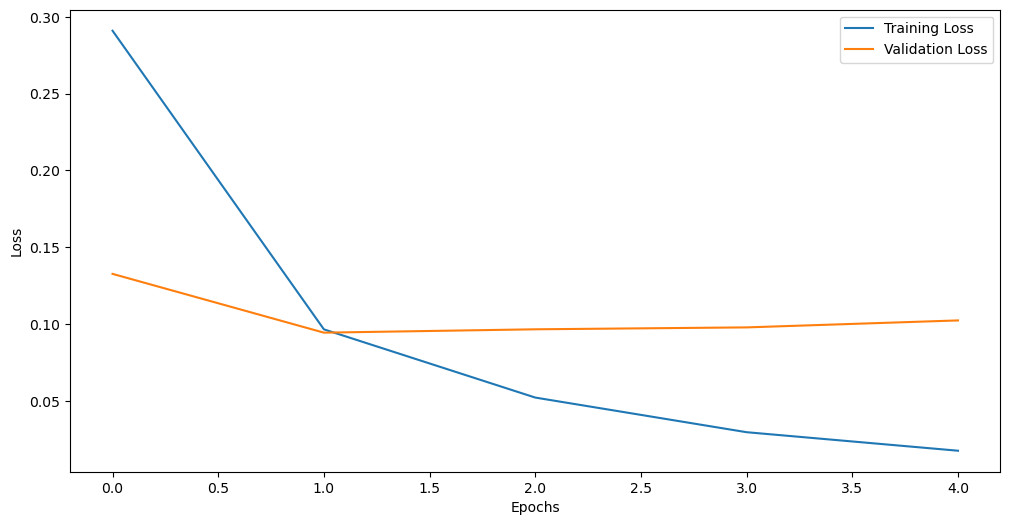

In [8]:
def load_kmnist():
    data = {}
    data['x_train'] = np.load('./data/kmnist-train-imgs.npz')['arr_0']
    data['y_train'] = np.load('./data/kmnist-train-labels.npz')['arr_0']
    data['x_test'] = np.load('./data/kmnist-test-imgs.npz')['arr_0']
    data['y_test'] = np.load('./data/kmnist-test-labels.npz')['arr_0']
    return data

data = load_kmnist()
x_train, x_val, y_train, y_val = train_test_split(data['x_train'], data['y_train'], test_size=0.2, random_state=42)
    
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = data['x_test'].astype('float32') / 255.0
y_test = data['y_test']

print('{} Train Samples, {} Validation Samples, {} Test Samples'.format(len(x_train), len(x_val), len(x_test)))

# Define the CNN architecture
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train[..., np.newaxis], y_train, epochs=5, validation_data=(x_val[..., np.newaxis], y_val))

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(x_test[..., np.newaxis], y_test)

# Print the accuracy and loss
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

# Generate predictions
predictions = model.predict(x_test[..., np.newaxis])
predicted_labels = np.argmax(predictions, axis=1)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the loss vs. iterations
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Same Basic CNN - Printing Confusion Matrices for all Sets of Data

48000 Train Samples, 12000 Validation Samples, 10000 Test Samples
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               692352    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 693,962
Trainable params: 693,962
Non-tr

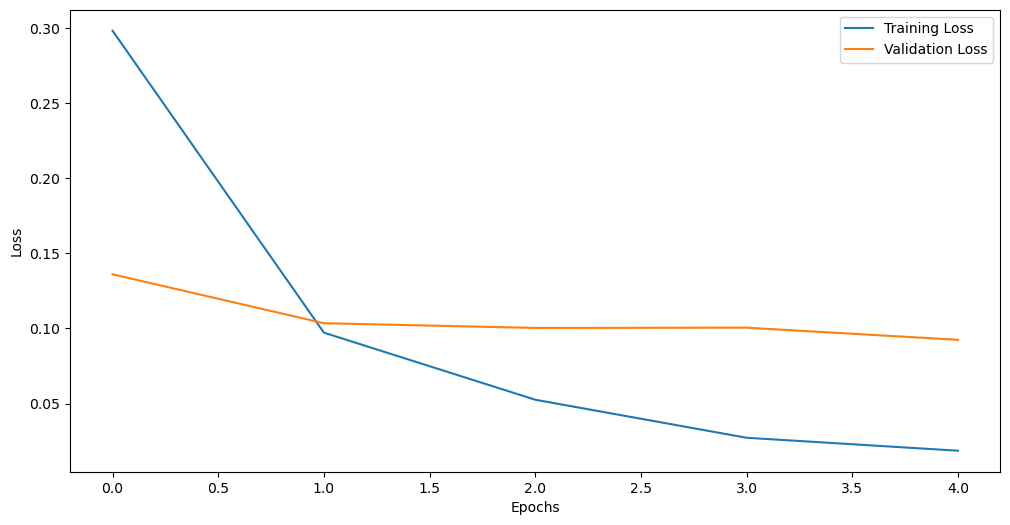

In [9]:
def load_kmnist():
    data = {}
    data['x_train'] = np.load('./data/kmnist-train-imgs.npz')['arr_0']
    data['y_train'] = np.load('./data/kmnist-train-labels.npz')['arr_0']
    data['x_test'] = np.load('./data/kmnist-test-imgs.npz')['arr_0']
    data['y_test'] = np.load('./data/kmnist-test-labels.npz')['arr_0']
    return data

data = load_kmnist()
x_train, x_val, y_train, y_val = train_test_split(data['x_train'], data['y_train'], test_size=0.2, random_state=42)
    
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = data['x_test'].astype('float32') / 255.0
y_test = data['y_test']

print('{} Train Samples, {} Validation Samples, {} Test Samples'.format(len(x_train), len(x_val), len(x_test)))

# Define the CNN architecture
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# Print the CNN architecture
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train[..., np.newaxis], y_train, epochs=5, validation_data=(x_val[..., np.newaxis], y_val))

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(x_test[..., np.newaxis], y_test)

# Print the accuracy and loss for test set
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

# Generate predictions for test set
predictions_test = model.predict(x_test[..., np.newaxis])
predicted_labels_test = np.argmax(predictions_test, axis=1)

# Generate predictions for training set
predictions_train = model.predict(x_train[..., np.newaxis])
predicted_labels_train = np.argmax(predictions_train, axis=1)

# Generate predictions for validation set
predictions_validation = model.predict(x_val[..., np.newaxis])
predicted_labels_validation = np.argmax(predictions_validation, axis=1)

# Create confusion matrices
conf_matrix_test = confusion_matrix(y_test, predicted_labels_test)
conf_matrix_train = confusion_matrix(y_train, predicted_labels_train)
conf_matrix_validation = confusion_matrix(y_val, predicted_labels_validation)

# Print the confusion matrices
print("\nConfusion Matrix (Test Set):")
print(conf_matrix_test)

print("\nConfusion Matrix (Training Set):")
print(conf_matrix_train)

print("\nConfusion Matrix (Validation Set):")
print(conf_matrix_validation)

# Plot the loss vs. iterations
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Increase Depth of CNN

48000 Train Samples, 12000 Validation Samples, 10000 Test Samples
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 64)       256       
 hNormalization)                                      

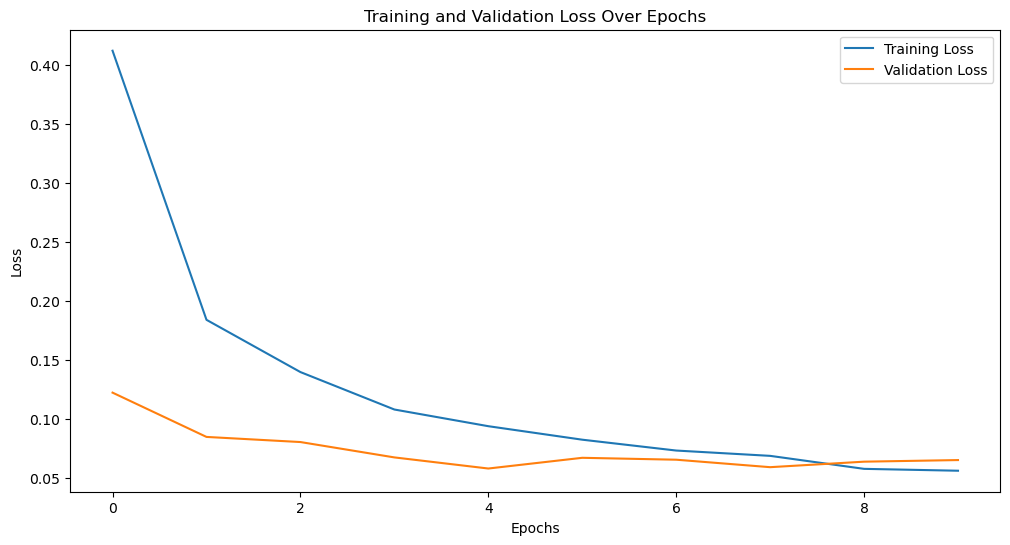

In [10]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
# from sklearn.metrics import accuracy_score, confusion_matrix
# import matplotlib.pyplot as plt

def load_kmnist():
    data = {}
    data['x_train'] = np.load('./data/kmnist-train-imgs.npz')['arr_0']
    data['y_train'] = np.load('./data/kmnist-train-labels.npz')['arr_0']
    data['x_test'] = np.load('./data/kmnist-test-imgs.npz')['arr_0']
    data['y_test'] = np.load('./data/kmnist-test-labels.npz')['arr_0']
    return data

data = load_kmnist()
x_train, x_val, y_train, y_val = train_test_split(data['x_train'], data['y_train'], test_size=0.2, random_state=42)
    
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = data['x_test'].astype('float32') / 255.0
y_test = data['y_test']

print('{} Train Samples, {} Validation Samples, {} Test Samples'.format(len(x_train), len(x_val), len(x_test)))

# Define a function to build the CNN model
def build_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(10, activation='softmax'))
    return model

model = build_model()
model.summary()

# Define a learning rate scheduler
def learning_rate_scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define model checkpoint to save the best model
model_checkpoint = ModelCheckpoint('best_deeper-cnn_model.h5', save_best_only=True)

# Compile the model with the learning rate scheduler
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train.reshape(-1, 28, 28, 1), y_train, epochs=30, validation_data=(x_val.reshape(-1, 28, 28, 1), y_val), callbacks=[early_stopping, LearningRateScheduler(learning_rate_scheduler)])

# Check if early stopping occurred
if early_stopping.stopped_epoch > 0:
    print(f"Early stopping at epoch {early_stopping.stopped_epoch + 1} as validation loss did not improve for {early_stopping.patience} consecutive epochs.")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test.reshape(-1, 28, 28, 1), y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions
y_pred = model.predict(x_test.reshape(-1, 28, 28, 1))
y_pred_classes = [np.argmax(y) for y in y_pred]

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

# Same Deeper CNN - Printing Confusion Matrices for all Sets of Data

48000 Train Samples, 12000 Validation Samples, 10000 Test Samples
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_2 (Batc  (None, 26, 26, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 11, 11, 64)       256       
 hNormalization)                                      

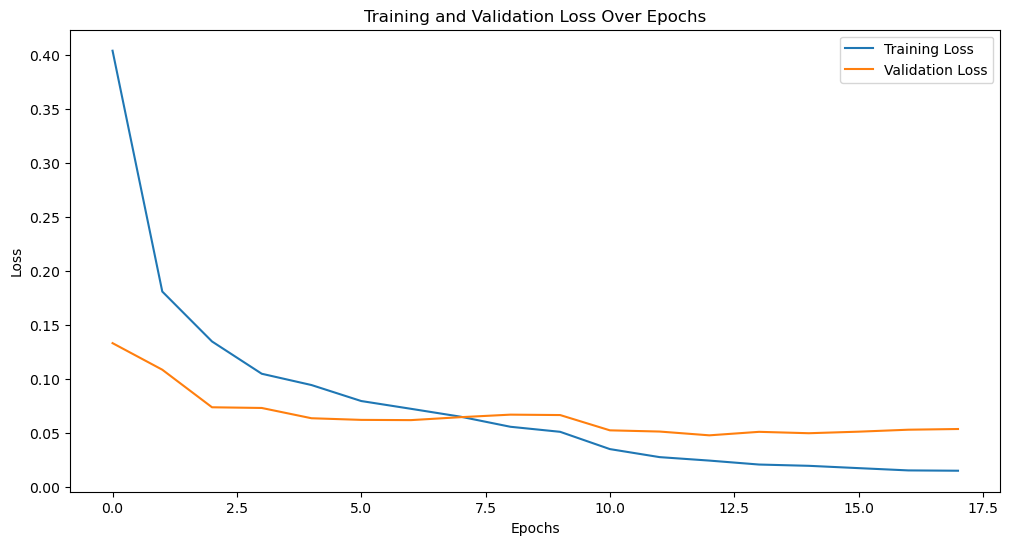

In [11]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.datasets import mnist
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
# from sklearn.metrics import accuracy_score, confusion_matrix
# import matplotlib.pyplot as plt

def load_kmnist():
    data = {}
    data['x_train'] = np.load('./data/kmnist-train-imgs.npz')['arr_0']
    data['y_train'] = np.load('./data/kmnist-train-labels.npz')['arr_0']
    data['x_test'] = np.load('./data/kmnist-test-imgs.npz')['arr_0']
    data['y_test'] = np.load('./data/kmnist-test-labels.npz')['arr_0']
    return data

data = load_kmnist()
x_train, x_val, y_train, y_val = train_test_split(data['x_train'], data['y_train'], test_size=0.2, random_state=42)
    
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = data['x_test'].astype('float32') / 255.0
y_test = data['y_test']

print('{} Train Samples, {} Validation Samples, {} Test Samples'.format(len(x_train), len(x_val), len(x_test)))

# Define a function to build the CNN model
def build_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(10, activation='softmax'))
    return model

model = build_model()
model.summary()

# Define a learning rate scheduler
def learning_rate_scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define model checkpoint to save the best model
model_checkpoint = ModelCheckpoint('best_deeper-cnn-with-matrices_model.h5', save_best_only=True)

# Compile the model with the learning rate scheduler
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train.reshape(-1, 28, 28, 1), y_train, epochs=30, validation_data=(x_val.reshape(-1, 28, 28, 1), y_val), callbacks=[early_stopping, LearningRateScheduler(learning_rate_scheduler)])

# Check if early stopping occurred
if early_stopping.stopped_epoch > 0:
    print(f"Early stopping at epoch {early_stopping.stopped_epoch + 1} as validation loss did not improve for {early_stopping.patience} consecutive epochs.")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test.reshape(-1, 28, 28, 1), y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions
y_pred = model.predict(x_test.reshape(-1, 28, 28, 1))
y_pred_classes = [np.argmax(y) for y in y_pred]

# Calculate and display the confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix (Test Set):")
print(conf_matrix_test)

# Generate predictions for the training and validation sets
y_train_pred = model.predict(x_train.reshape(-1, 28, 28, 1))
y_val_pred = model.predict(x_val.reshape(-1, 28, 28, 1))

# Calculate and display the confusion matrices for training and validation sets
conf_matrix_train = confusion_matrix(y_train, [np.argmax(y) for y in y_train_pred])
conf_matrix_val = confusion_matrix(y_val, [np.argmax(y) for y in y_val_pred])

print("\nConfusion Matrix (Training Set):")
print(conf_matrix_train)

print("\nConfusion Matrix (Validation Set):")
print(conf_matrix_val)

# Plot the training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

# Deeper CNN with K-Fold Cross Validation

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

def load_kmnist():
    data = {}
    data['x_train'] = np.load('./data/kmnist-train-imgs.npz')['arr_0']
    data['y_train'] = np.load('./data/kmnist-train-labels.npz')['arr_0']
    data['x_test'] = np.load('./data/kmnist-test-imgs.npz')['arr_0']
    data['y_test'] = np.load('./data/kmnist-test-labels.npz')['arr_0']
    return data

data = load_kmnist()
# x_train, x_val, y_train, y_val = train_test_split(data['x_train'], data['y_train'], test_size=0.2, random_state=42)
    
x_train = data['x_train'].astype('float32') / 255.0
y_train = data['y_train']
x_test = data['x_test'].astype('float32') / 255.0
y_test = data['y_test']

print('{} Train Samples, {} Test Samples'.format(len(x_train), len(x_test)))

# Define a function to build the CNN model
def build_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(10, activation='softmax'))
    return model

model = build_model()
model.summary()

# Define a learning rate scheduler
def learning_rate_scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0

# Initialize lists to store accuracies
train_accuracies = []
val_accuracies = []
test_accuracies = []

for train_index, val_index in kf.split(x_train):
    fold += 1
    print(f"Fold {fold}/{kf.get_n_splits()}")

    # Split the data into train and validation sets for this fold
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Compile the model with the learning rate scheduler
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model for this fold
    history = model.fit(x_train_fold.reshape(-1, 28, 28, 1), y_train_fold, epochs=30,
                        validation_data=(x_val_fold.reshape(-1, 28, 28, 1), y_val_fold),
                        callbacks=[early_stopping, LearningRateScheduler(learning_rate_scheduler)],
                        verbose=0)
    
    # Check if early stopping occurred
    if early_stopping.stopped_epoch > 0:
        print(f"Early stopping at epoch {early_stopping.stopped_epoch + 1} as validation loss did not improve for {early_stopping.patience} consecutive epochs.")
    
    # Evaluate the model on the training set for this fold
    train_loss, train_accuracy = model.evaluate(x_train_fold.reshape(-1, 28, 28, 1), y_train_fold)
    print(f"Training Accuracy (Fold {fold}): {train_accuracy:.4f}")
    train_accuracies.append(train_accuracy)
    
    # # Evaluate the model on the training set for this fold
    # val_loss, val_accuracy = model.evaluate(x_val_fold.reshape(-1, 28, 28, 1), y_val_fold)
    # print(f"Validation Accuracy (Fold {fold}): {val_accuracy:.4f}")
    # val_accuracies.append(val_accuracy)
    
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(x_test.reshape(-1, 28, 28, 1), y_test)
    print(f"Test Accuracy (Fold {fold}): {test_accuracy:.4f}")
    test_accuracies.append(test_accuracy)

    # Generate predictions for the test set
    y_pred = model.predict(x_test.reshape(-1, 28, 28, 1))
    y_pred_classes = [np.argmax(y) for y in y_pred]

    # Calculate and display the confusion matrix for the test set
    conf_matrix_test = confusion_matrix(y_test, y_pred_classes)
    print(f"Confusion Matrix (Test Set - Fold {fold}):")
    print(conf_matrix_test)

# Print the average test and train accuracies across folds
print(f"Average Training Accuracy: {np.mean(train_accuracies):.4f}")
# print(f"Average Validation Accuracy: {np.mean(val_accuracies):.4f}")
print(f"Average Test Accuracy: {np.mean(test_accuracies):.4f}")

60000 Train Samples, 10000 Test Samples
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 64)       256       
 hNormalization)                                                 
                

# Same Deeper CNN with K-Fold Cross Validation + Loss Curves at Each Fold

60000 Train Samples, 10000 Test Samples
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 64)       256       
 hNormalization)                                                 
                

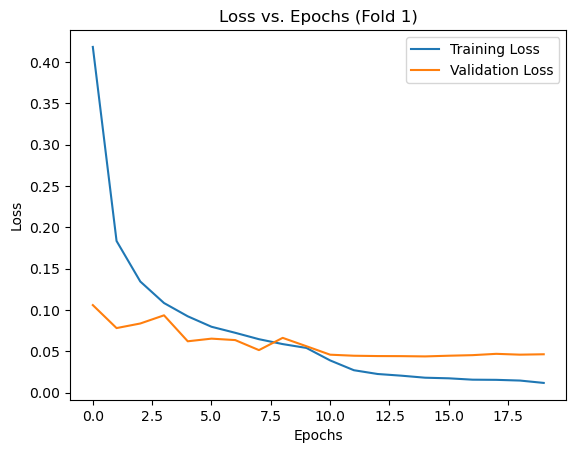

1500/1500 [==============================] - 8s 6ms/step - loss: 0.0015 - accuracy: 0.9998
Training Accuracy (Fold 1): 0.9998
313/313 [==============================] - 3s 9ms/step - loss: 0.2053 - accuracy: 0.9636
Test Accuracy (Fold 1): 0.9636
Confusion Matrix (Test Set - Fold 1):
[[964   3   2   0  21   2   0   6   2   0]
 [  0 947   2   0   8   1  21   4   6  11]
 [  7   0 932  24   8   7   9   7   3   3]
 [  0   0   6 984   1   4   4   0   1   0]
 [  7   1   1   9 952   4   7   5  13   1]
 [  1   4  15   5   3 951   6   0   7   8]
 [  0   2   7   3   2   2 981   2   0   1]
 [  2   2   1   1   7   2  11 970   3   1]
 [  1   2   2   3   3   2   2   0 984   1]
 [  7   2   1   0   5   2   2   5   5 971]]
Fold 2/5
Early stopping at epoch 6 as validation loss did not improve for 5 consecutive epochs.


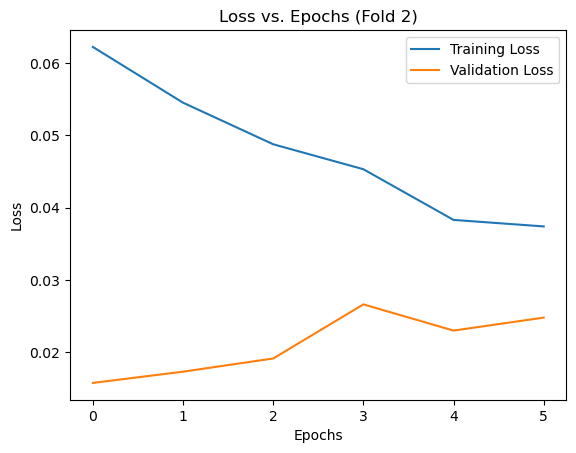

1500/1500 [==============================] - 10s 7ms/step - loss: 0.0133 - accuracy: 0.9961
Training Accuracy (Fold 2): 0.9961
313/313 [==============================] - 3s 8ms/step - loss: 0.2212 - accuracy: 0.9545
Test Accuracy (Fold 2): 0.9545
Confusion Matrix (Test Set - Fold 2):
[[952   4   1   1  15  17   1   3   4   2]
 [  1 949   2   0   8   4  18   0   7  11]
 [  6   0 940  13  10  13  10   2   3   3]
 [  0   0  10 978   1   7   4   0   0   0]
 [  8   2   6  12 947   8   6   1   7   3]
 [  1   5  12   3   0 960  12   0   4   3]
 [  1   3  14   5   3   2 970   2   0   0]
 [  6   2   2   3  22   8  27 916   6   8]
 [  0   4   2   2  11   4   5   0 971   1]
 [  4   3   3   1   9   6   4   4   4 962]]
Fold 3/5
Early stopping at epoch 7 as validation loss did not improve for 5 consecutive epochs.


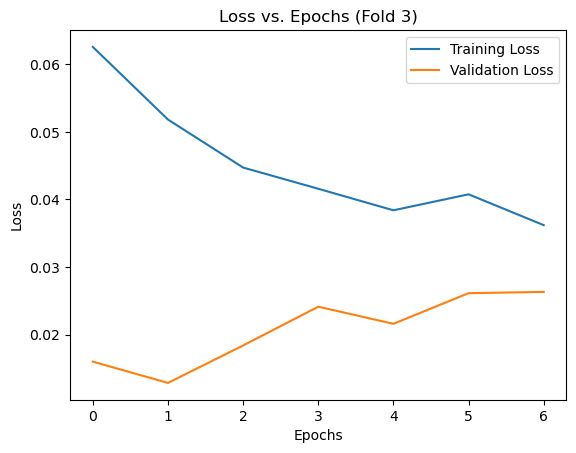

1500/1500 [==============================] - 9s 6ms/step - loss: 0.0077 - accuracy: 0.9976
Training Accuracy (Fold 3): 0.9976
313/313 [==============================] - 3s 9ms/step - loss: 0.2020 - accuracy: 0.9602
Test Accuracy (Fold 3): 0.9602
Confusion Matrix (Test Set - Fold 3):
[[957   2   1   0  17   2   1  10   5   5]
 [  1 951   5   0   0   0  14   3   6  20]
 [  5   1 923  19   9   2  27   5   4   5]
 [  0   1   2 982   1   2   8   3   1   0]
 [  5   3   4   6 945   1   7  10  10   9]
 [  1   5  22   8   1 931   9   0  10  13]
 [  0   3  10   0   2   1 979   2   2   1]
 [  5   0   2   1   4   0   4 976   2   6]
 [  2   3   3   2   5   0   1   0 978   6]
 [  5   1   2   0   1   0   3   3   5 980]]
Fold 4/5
Early stopping at epoch 7 as validation loss did not improve for 5 consecutive epochs.


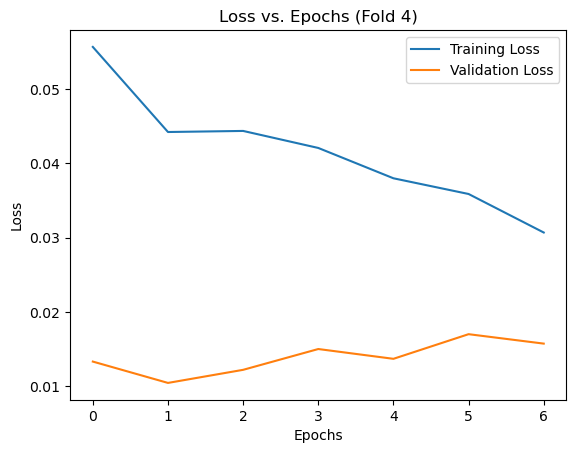

1500/1500 [==============================] - 11s 7ms/step - loss: 0.0072 - accuracy: 0.9983
Training Accuracy (Fold 4): 0.9983
313/313 [==============================] - 3s 8ms/step - loss: 0.2043 - accuracy: 0.9608
Test Accuracy (Fold 4): 0.9608
Confusion Matrix (Test Set - Fold 4):
[[967   3   2   0  17   2   0   7   2   0]
 [  1 938   3   1   8   2  16   5   7  19]
 [  9   0 942  15   7   7   8   5   2   5]
 [  0   1   6 978   2   4   5   1   2   1]
 [ 14   2   2   9 942   3   5   6  10   7]
 [  3   3  16   5   1 941   7   7   7  10]
 [  3   3   6   2   4   1 975   5   1   0]
 [  6   1   2   1   3   0   4 977   2   4]
 [  3   4   2   3   6   1   1   1 973   6]
 [  7   1   1   0   3   1   3   3   6 975]]
Fold 5/5
Early stopping at epoch 7 as validation loss did not improve for 5 consecutive epochs.


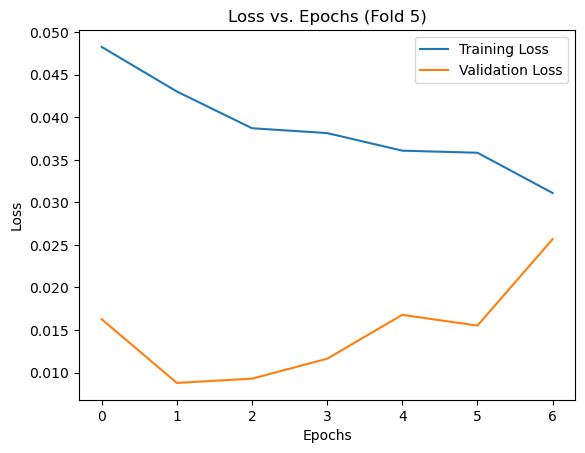

1500/1500 [==============================] - 10s 7ms/step - loss: 0.0052 - accuracy: 0.9983
Training Accuracy (Fold 5): 0.9983
313/313 [==============================] - 3s 9ms/step - loss: 0.2591 - accuracy: 0.9617
Test Accuracy (Fold 5): 0.9617
Confusion Matrix (Test Set - Fold 5):
[[961   3   1   0  16   6   0   4   6   3]
 [  1 944   5   0   5   1  20   2   3  19]
 [  9   1 933  15   8   5  14   4   3   8]
 [  0   1   9 985   1   1   3   0   0   0]
 [  5   2   4   9 955   5   4   4   8   4]
 [  1   8  17   2   3 940  13   0   7   9]
 [  0   1   3   3   3   1 984   2   1   2]
 [  5   2   0   1   3   1   8 961   7  12]
 [  1   6   0   3   5   2   6   0 972   5]
 [  4   4   0   0   3   0   0   3   4 982]]
Average Training Accuracy: 0.9980
Average Test Accuracy: 0.9602


In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

def load_kmnist():
    data = {}
    data['x_train'] = np.load('./data/kmnist-train-imgs.npz')['arr_0']
    data['y_train'] = np.load('./data/kmnist-train-labels.npz')['arr_0']
    data['x_test'] = np.load('./data/kmnist-test-imgs.npz')['arr_0']
    data['y_test'] = np.load('./data/kmnist-test-labels.npz')['arr_0']
    return data

data = load_kmnist()
# x_train, x_val, y_train, y_val = train_test_split(data['x_train'], data['y_train'], test_size=0.2, random_state=42)
    
x_train = data['x_train'].astype('float32') / 255.0
y_train = data['y_train']
x_test = data['x_test'].astype('float32') / 255.0
y_test = data['y_test']

print('{} Train Samples, {} Test Samples'.format(len(x_train), len(x_test)))

# Define a function to build the CNN model
def build_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(10, activation='softmax'))
    return model

model = build_model()
model.summary()

# Define a learning rate scheduler
def learning_rate_scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0

# Initialize lists to store results
train_accuracies = []
# val_accuracies = []
test_accuracies = []

for train_index, val_index in kf.split(x_train):
    fold += 1
    print(f"Fold {fold}/{kf.get_n_splits()}")

    # Split the data into train and validation sets for this fold
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Compile the model with the learning rate scheduler
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model for this fold
    history = model.fit(x_train_fold.reshape(-1, 28, 28, 1), y_train_fold, epochs=30,
                        validation_data=(x_val_fold.reshape(-1, 28, 28, 1), y_val_fold),
                        callbacks=[early_stopping, LearningRateScheduler(learning_rate_scheduler)],
                        verbose=0)

    # Check if early stopping occurred
    if early_stopping.stopped_epoch > 0:
        print(f"Early stopping at epoch {early_stopping.stopped_epoch + 1} as validation loss did not improve for {early_stopping.patience} consecutive epochs.")

    # Plot loss vs. epochs for this fold
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss vs. Epochs (Fold {fold})')
    plt.legend()
    plt.show()

    # Evaluate the model on the training set for this fold
    train_loss, train_accuracy = model.evaluate(x_train_fold.reshape(-1, 28, 28, 1), y_train_fold)
    print(f"Training Accuracy (Fold {fold}): {train_accuracy:.4f}")
    train_accuracies.append(train_accuracy)
    
    # # Evaluate the model on the training set for this fold
    # val_loss, val_accuracy = model.evaluate(x_val_fold.reshape(-1, 28, 28, 1), y_val_fold)
    # print(f"Validation Accuracy (Fold {fold}): {val_accuracy:.4f}")
    # val_accuracies.append(val_accuracy)
    
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(x_test.reshape(-1, 28, 28, 1), y_test)
    print(f"Test Accuracy (Fold {fold}): {test_accuracy:.4f}")
    test_accuracies.append(test_accuracy)

    # Generate predictions for the test set
    y_pred = model.predict(x_test.reshape(-1, 28, 28, 1))
    y_pred_classes = [np.argmax(y) for y in y_pred]

    # Calculate and display the confusion matrix for the test set
    conf_matrix_test = confusion_matrix(y_test, y_pred_classes)
    print(f"Confusion Matrix (Test Set - Fold {fold}):")
    print(conf_matrix_test)

# Print the average test and train accuracies across folds
print(f"Average Training Accuracy: {np.mean(train_accuracies):.4f}")
# print(f"Average Validation Accuracy: {np.mean(val_accuracies):.4f}")
print(f"Average Test Accuracy: {np.mean(test_accuracies):.4f}")

# Searching for Best HyperParameters with K-Fold Cross Validation

In [1]:
import tensorflow as tf
import torch
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

print(device_lib.list_local_devices())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6258348740363715151
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 78238842880
locality {
  bus_id: 8
  numa_node: 7
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 16088541030381909358
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 82744508416
locality {
  bus_id: 6
  numa_node: 5
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 9882873615399509193
physical_device_desc: "device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b7:00.0, compute capabili

2023-10-25 10:05:25.579826: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 10:05:28.062230: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 74614 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0
2023-10-25 10:05:28.063962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b7:00.0, compute capability: 8.0
2023-10-25 10:05:28.065551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 78911 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, 

60000 Train Samples, 10000 Test Samples
Fold 1/5 - Learning Rate: 0.1, Dropout Rate: 0.3


2023-10-25 10:05:28.437183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 74614 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0
2023-10-25 10:05:28.440241: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b7:00.0, compute capability: 8.0
2023-10-25 10:05:28.441721: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 78911 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:bd:00.0, compute capability: 8.0
2023-10-25 10:05:36.471102: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8500
2023-10-25 10:05:42.241761: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for

Early stopping at epoch 9 as validation loss did not improve for 5 consecutive epochs.
313/313 [==============================] - 1s 1ms/step - loss: 0.2245 - accuracy: 0.9478
Test Accuracy (Fold 1): 0.9478
Fold 2/5 - Learning Rate: 0.1, Dropout Rate: 0.3
Early stopping at epoch 9 as validation loss did not improve for 5 consecutive epochs.
313/313 [==============================] - 0s 1ms/step - loss: 0.2458 - accuracy: 0.9457
Test Accuracy (Fold 2): 0.9457
Fold 3/5 - Learning Rate: 0.1, Dropout Rate: 0.3
Early stopping at epoch 19 as validation loss did not improve for 5 consecutive epochs.
313/313 [==============================] - 0s 1ms/step - loss: 0.2359 - accuracy: 0.9630
Test Accuracy (Fold 3): 0.9630
Fold 4/5 - Learning Rate: 0.1, Dropout Rate: 0.3
Early stopping at epoch 18 as validation loss did not improve for 5 consecutive epochs.
313/313 [==============================] - 0s 1ms/step - loss: 0.2255 - accuracy: 0.9640
Test Accuracy (Fold 4): 0.9640
Fold 5/5 - Learning Rat

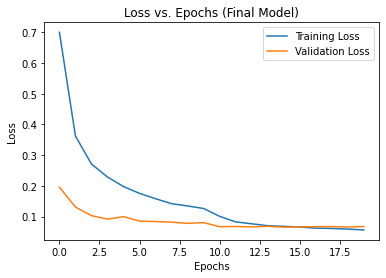

In [2]:
def load_kmnist():
    data = {}
    data['x_train'] = np.load('/blue/thai/t.jeter/NN/data/kmnist-train-imgs.npz')['arr_0']
    data['y_train'] = np.load('/blue/thai/t.jeter/NN/data/kmnist-train-labels.npz')['arr_0']
    data['x_test'] = np.load('/blue/thai/t.jeter/NN/data/kmnist-test-imgs.npz')['arr_0']
    data['y_test'] = np.load('/blue/thai/t.jeter/NN/data/kmnist-test-labels.npz')['arr_0']
    return data

data = load_kmnist()
# x_train, x_val, y_train, y_val = train_test_split(data['x_train'], data['y_train'], test_size=0.2, random_state=42)
    
x_train = data['x_train'].astype('float32') / 255.0
y_train = data['y_train']
x_test = data['x_test'].astype('float32') / 255.0
y_test = data['y_test']

print('{} Train Samples, {} Test Samples'.format(len(x_train), len(x_test)))

# Define a function to build the CNN model with hyperparameters
def build_model(learning_rate=0.001, dropout_rate=0.5):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout for regularization
    model.add(Dense(10, activation='softmax'))

    # Compile the model with the specified learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Define a learning rate scheduler
def learning_rate_scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Initialize k-fold cross-validation for hyperparameter tuning
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store hyperparameters and corresponding test accuracies
hyperparameters = []
test_accuracies = []

# Hyperparameter tuning loop
for learning_rate in [0.1, 0.01, 0.001, 0.0001]:
    for dropout_rate in [0.3, 0.5, 0.7]:
        fold = 0
        fold_test_accuracies = []

        for train_index, val_index in kf.split(x_train):
            fold += 1
            print(f"Fold {fold}/{kf.get_n_splits()} - Learning Rate: {learning_rate}, Dropout Rate: {dropout_rate}")

            # Split the data into train and validation sets for this fold
            x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            # Early stopping criteria
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

            model = build_model(learning_rate=learning_rate, dropout_rate=dropout_rate)

            # Train the model for this fold
            history = model.fit(x_train_fold.reshape(-1, 28, 28, 1), y_train_fold, epochs=30,
                                validation_data=(x_val_fold.reshape(-1, 28, 28, 1), y_val_fold),
                                callbacks=[early_stopping, LearningRateScheduler(learning_rate_scheduler)],
                                verbose=0)

            # Check if early stopping occurred
            if early_stopping.stopped_epoch > 0:
                print(f"Early stopping at epoch {early_stopping.stopped_epoch + 1} as validation loss did not improve for {early_stopping.patience} consecutive epochs.")
            
            # Evaluate the model on the test set
            test_loss, test_accuracy = model.evaluate(x_test.reshape(-1, 28, 28, 1), y_test)
            print(f"Test Accuracy (Fold {fold}): {test_accuracy:.4f}")
            fold_test_accuracies.append(test_accuracy)

        # Calculate the mean test accuracy for this hyperparameter combination
        mean_test_accuracy = np.mean(fold_test_accuracies)

        # Store the hyperparameters and mean test accuracy
        hyperparameters.append((learning_rate, dropout_rate))
        test_accuracies.append(mean_test_accuracy)

# Find the best hyperparameter combination based on test accuracy
best_hyperparameters = hyperparameters[np.argmax(test_accuracies)]
best_learning_rate, best_dropout_rate = best_hyperparameters

# Early stopping criteria
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the final model on the entire training dataset with the best hyperparameters
final_model = build_model(learning_rate=best_learning_rate, dropout_rate=best_dropout_rate)

# Print the final model architecture
final_model.summary()

# Print the best hyperparameters
print(f"Best Learning Rate: {best_learning_rate}")
print(f"Best Dropout Rate: {best_dropout_rate}")

final_model.fit(x_train.reshape(-1, 28, 28, 1), y_train, epochs=30,
                callbacks=[early_stopping, LearningRateScheduler(learning_rate_scheduler)],
                verbose=1)

# Evaluate the final model on the test set
final_test_loss, final_test_accuracy = final_model.evaluate(x_test.reshape(-1, 28, 28, 1), y_test)
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")

# Generate predictions for the test set
y_pred = final_model.predict(x_test.reshape(-1, 28, 28, 1))
y_pred_classes = [np.argmax(y) for y in y_pred]

# Calculate and display the confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix (Test Set):")
print(conf_matrix_test)

# Plot loss vs. epochs for the final model
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Final Model)')
plt.legend()
plt.show()